In [1]:


import numpy as np # linear algebra
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/Users/letiendat/Documents/Semes-Six/TGMT/Facial-Emotion-Recognition/Data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/Users/letiendat/Documents/Semes-Six/TGMT/Facial-Emotion-Recognition/Data/.DS_Store
/Users/letiendat/Documents/Semes-Six/TGMT/Facial-Emotion-Recognition/Data/Submission.csv
/Users/letiendat/Documents/Semes-Six/TGMT/Facial-Emotion-Recognition/Data/fer2013/fer2013/fer2013.csv
/Users/letiendat/Documents/Semes-Six/TGMT/Facial-Emotion-Recognition/Data/fer2013/fer2013/fer2013.bib
/Users/letiendat/Documents/Semes-Six/TGMT/Facial-Emotion-Recognition/Data/fer2013/fer2013/README


In [2]:
import math
import numpy as np
import pandas as pd

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.utils import to_categorical


In [3]:
df = pd.read_csv('/Users/letiendat/Documents/Semes-Six/TGMT/Facial-Emotion-Recognition/Data/fer2013/fer2013/fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [5]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [6]:
df.emotion.value_counts()

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

In [7]:
# sns.countplot(df.emotion)
# pyplot.show()

`So majority classes belongs to 3:Happy, 4:Sad and 6:Neutral nd we are also intersted in these three classes only.`

In [8]:
math.sqrt(len(df.pixels[0].split(' ')))

48.0

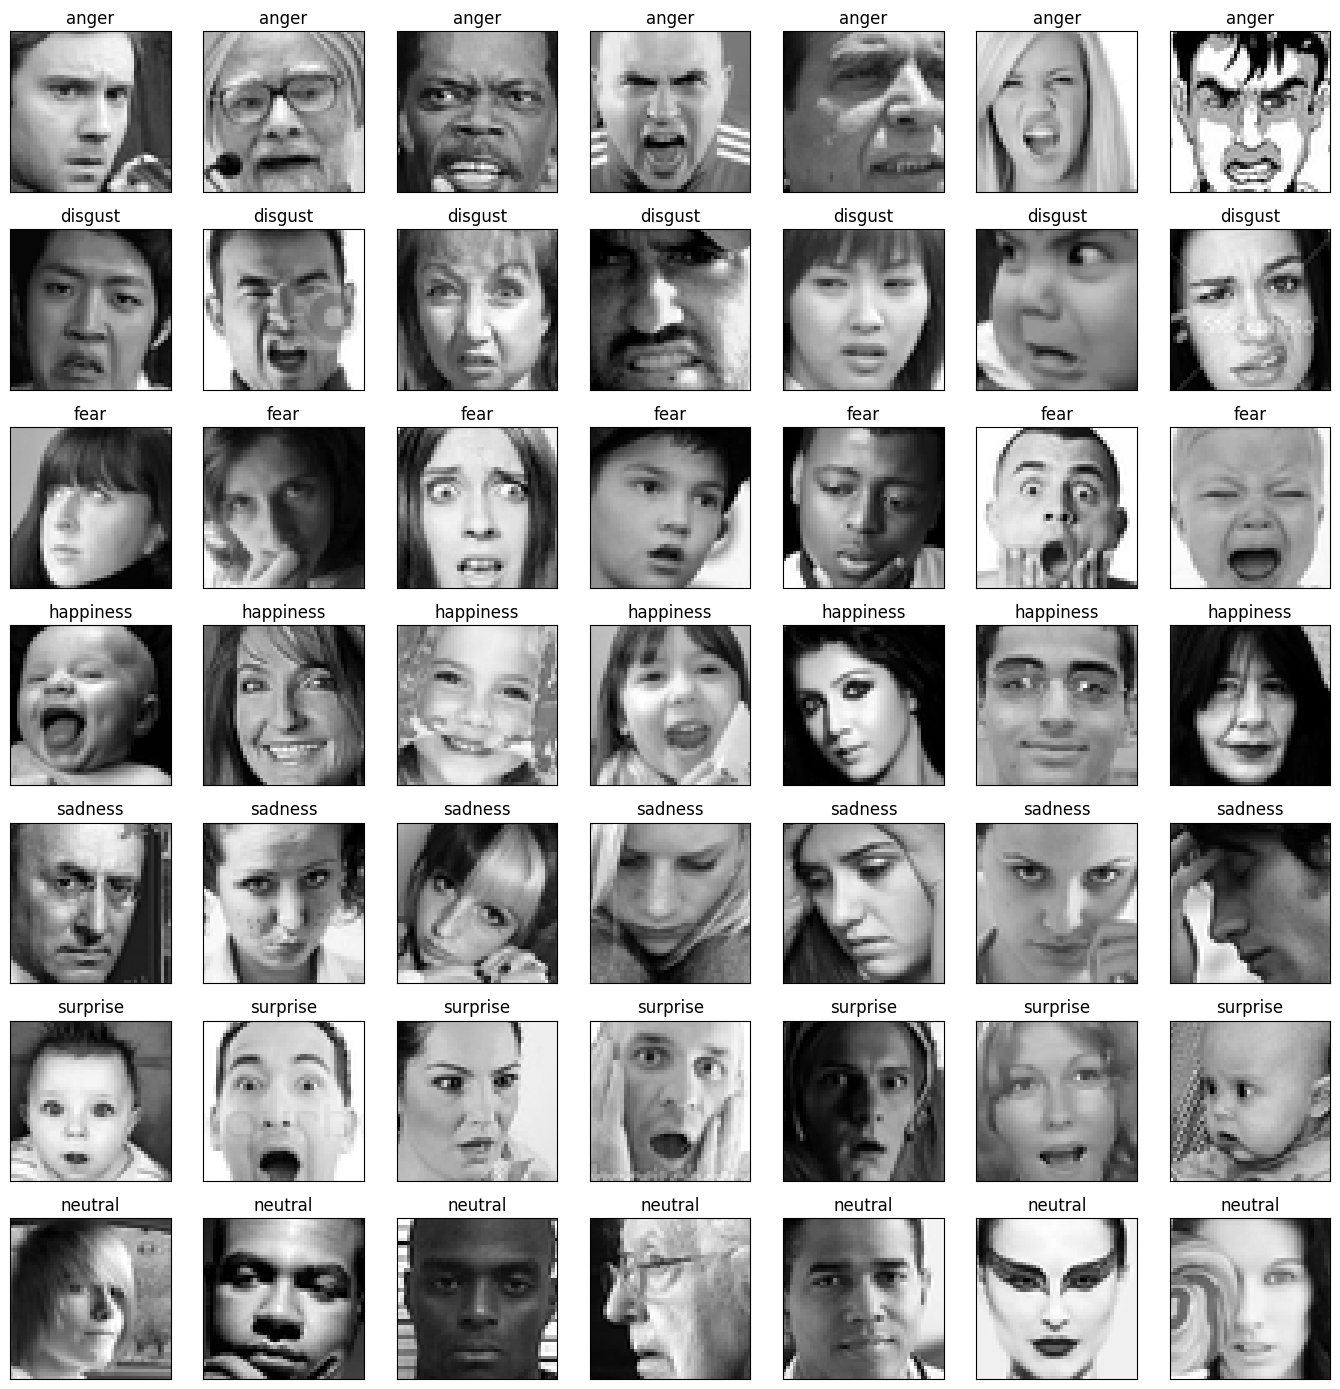

In [9]:
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

In [10]:
INTERESTED_LABELS = [0, 1, 2, 3, 4, 5, 6]

In [11]:
df = df[df.emotion.isin(INTERESTED_LABELS)]
df.shape

(35887, 3)

`Now I will make the data compatible for neural networks.`

In [12]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [13]:
img_array.shape

(35887, 48, 48, 1)

In [14]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = to_categorical(img_labels)
img_labels.shape

(35887, 7)

In [15]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}


`Splitting the data into training and validation set.`

In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.1, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((32298, 48, 48, 1), (3589, 48, 48, 1), (32298, 7), (3589, 7))

In [17]:
del df
del img_array
del img_labels

In [18]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [19]:
# Normalizing results, as neural networks are very sensitive to unnormalized data.
X_train = X_train / 255.
X_valid = X_valid / 255.

In [20]:
def build_net(optim):
    """
    This is a Deep Convolutional Neural Network (DCNN). For generalization purpose I used dropouts in regular intervals.
    I used `ELU` as the activation because it avoids dying relu problem but also performed well as compared to LeakyRelu
    atleast in this case. `he_normal` kernel initializer is used as it suits ELU. BatchNormalization is also used for better
    results.
    """
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))
        
    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    
    net.add(Dropout(0.6, name='dropout_4'))
    
    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )
    
    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )
    
    net.summary()
    
    return net

In [21]:
"""
I used two callbacks one is `early stopping` for avoiding overfitting training data
and other `ReduceLROnPlateau` for learning rate.
"""

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [22]:
# As the data in hand is less as compared to the task so ImageDataGenerator is good to go.
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

In [25]:
batch_size = 32 #batch size of 32 performs the best.
epochs = 100
optims = [
    optimizers.legacy.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Adam'),
    optimizers.Adam(0.001),
]

# I tried both `Nadam` and `Adam`, the difference in results is not different but I finally went with Nadam as it is more popular.
model = build_net(optims[1]) 
# history = model.fit(
#     train_datagen.flow(X_train, y_train, batch_size=batch_size),
#     validation_data=(X_valid, y_valid),
#     steps_per_epoch=len(X_train) / batch_size,
#     epochs=epochs,
#     callbacks=callbacks,
#     use_multiprocessing=True
# )
    
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks
)


Model: "DCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        1664      
                                                                 
 batchnorm_1 (BatchNormaliz  (None, 48, 48, 64)        256       
 ation)                                                          
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batchnorm_2 (BatchNormaliz  (None, 48, 48, 64)        256       
 ation)                                                          
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 64)        0      

2023-12-23 06:20:33.433813: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


1009/1009 [==============================] - 264s 259ms/step - loss: 1.9634 - accuracy: 0.2443 - val_loss: 1.6889 - val_accuracy: 0.3497 - lr: 0.0010
Epoch 2/100
1009/1009 [==============================] - 269s 267ms/step - loss: 1.6423 - accuracy: 0.3490 - val_loss: 1.6313 - val_accuracy: 0.3962 - lr: 0.0010
Epoch 3/100
1009/1009 [==============================] - 301s 298ms/step - loss: 1.4608 - accuracy: 0.4335 - val_loss: 1.2737 - val_accuracy: 0.5177 - lr: 0.0010
Epoch 4/100
1009/1009 [==============================] - 279s 277ms/step - loss: 1.3545 - accuracy: 0.4771 - val_loss: 1.3815 - val_accuracy: 0.4781 - lr: 0.0010
Epoch 5/100
1009/1009 [==============================] - 307s 304ms/step - loss: 1.2800 - accuracy: 0.5138 - val_loss: 1.2641 - val_accuracy: 0.5327 - lr: 0.0010
Epoch 6/100
1009/1009 [==============================] - 271s 269ms/step - loss: 1.2315 - accuracy: 0.5325 - val_loss: 1.1489 - val_accuracy: 0.5631 - lr: 0.0010
Epoch 7/100
1009/1009 [=================

In [30]:
# model_yaml = model.to_yaml()
# with open("model.yaml", "w") as yaml_file:
#     yaml_file.write(model_yaml)

from keras.models import model_from_json

# Convert model to JSON format
model_json = model.to_json()

# Save the model architecture to a JSON file
with open("model.json", "w") as json_file:
    json_file.write(model_json)
    
model.save("model.h5")


/Users/letiendat/miniforge3/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


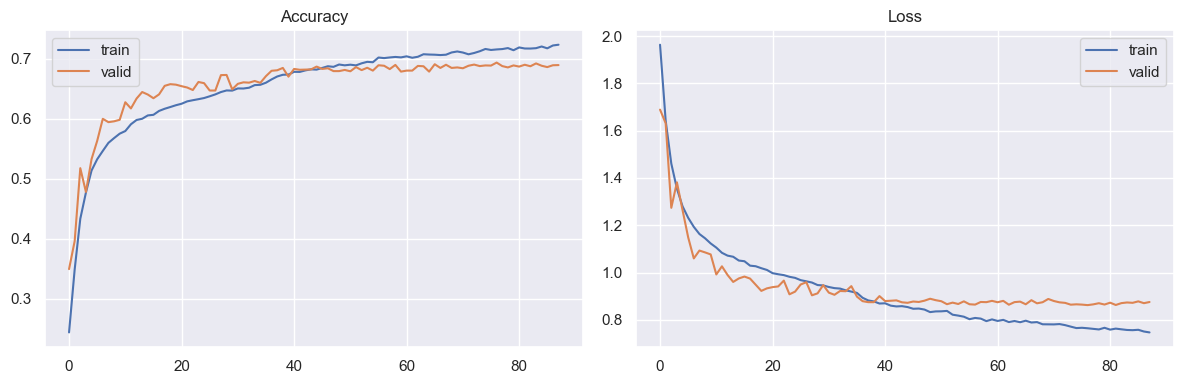

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot Accuracy
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train', ax=axes[0])
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid', ax=axes[0])
axes[0].set_title('Accuracy')

# Plot Loss
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train', ax=axes[1])
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid', ax=axes[1])
axes[1].set_title('Loss')

plt.tight_layout()

# Save the figure
plt.savefig('epoch_history_dcnn.png')

# Show the plot
plt.show()


    The epochs history shows that accuracy gradually increases and achieved +83% accuracy on both training and validation set, but at the end the model starts overfitting training data.

113/113 [==============================] - 11s 97ms/step
total wrong validation predictions: 1100


              precision    recall  f1-score   support

       Angry       0.59      0.68      0.63       495
     Disgust       0.69      0.67      0.68        55
        Fear       0.56      0.47      0.51       512
       Happy       0.90      0.86      0.88       899
     Neutral       0.62      0.56      0.59       608
         Sad       0.76      0.77      0.77       400
    Surprise       0.63      0.74      0.68       620

    accuracy                           0.69      3589
   macro avg       0.68      0.68      0.68      3589
weighted avg       0.70      0.69      0.69      3589



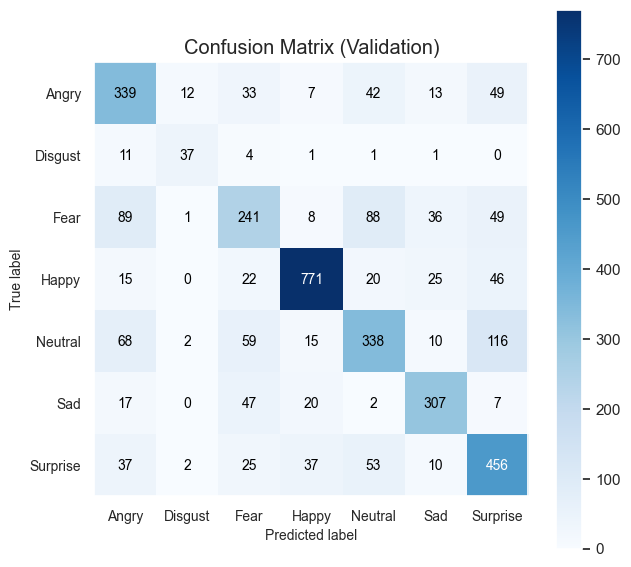

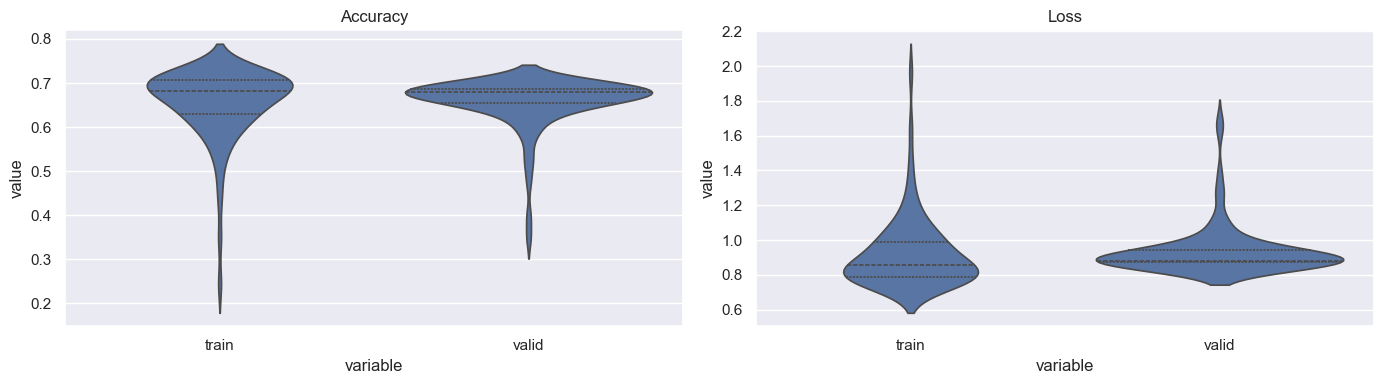

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scikitplot.metrics
from sklearn.metrics import classification_report
import numpy as np

mapper = {
    0: "Angry",
    1: "Disgust",
    2: "Fear",
    3: "Happy",
    4: "Neutral",
    5: "Sad",
    6: "Surprise"
}



# Assuming you have a Sequential model named 'model'
yhat_valid_prob = model.predict(X_valid)
yhat_valid = np.argmax(yhat_valid_prob, axis=1)

# Plot confusion matrix
fig = plt.figure(figsize=(7, 7))
class_labels = [mapper[i] for i in range(len(mapper))]
scikitplot.metrics.plot_confusion_matrix([mapper[i] for i in np.argmax(y_valid, axis=1)],
                                        [mapper[i] for i in yhat_valid],
                                        ax=plt.gca(),
                                        title=f'Confusion Matrix (Validation)',
                                        text_fontsize='small',
                                        cmap='Blues')
plt.savefig("confusion_matrix_dcnn.png")

# Print additional information
print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')
print(classification_report([mapper[i] for i in np.argmax(y_valid, axis=1)],
                            [mapper[i] for i in yhat_valid]))

# Additional code for the performance distribution plots
df_accu = pd.DataFrame({'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
df_loss = pd.DataFrame({'train': history.history['loss'], 'valid': history.history['val_loss']})

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Plot Accuracy
sns.violinplot(x="variable", y="value", data=pd.melt(df_accu), inner='quartile', ax=axes[0])
axes[0].set_title('Accuracy')

# Plot Loss
sns.violinplot(x="variable", y="value", data=pd.melt(df_loss), inner='quartile', ax=axes[1])
axes[1].set_title('Loss')

plt.tight_layout()

# Save the performance distribution figure
plt.savefig('performance_dist.png')

# Show the performance distribution plot
plt.show()



The confusion matrix clearly shows that our model is doing good job on the class `happy` but it's performance is low on other two classes. One of the reason for this could be the fact that these two classes have less data. But when I looked at the images I found some images from these two classes are even hard for a human to tell whether the person is sad or neutral. Facial expression depends on individual as well. Some person's neutral face looks like sad.

In [44]:
mapper = {
    0: "Angry",
    1: "Disgust",
    2: "Fear",
    3: "Happy",
    4: "Neutral",
    5: "Sad",
    6: "Surprise"
}

1/1 [==============================] - 0s 32ms/step


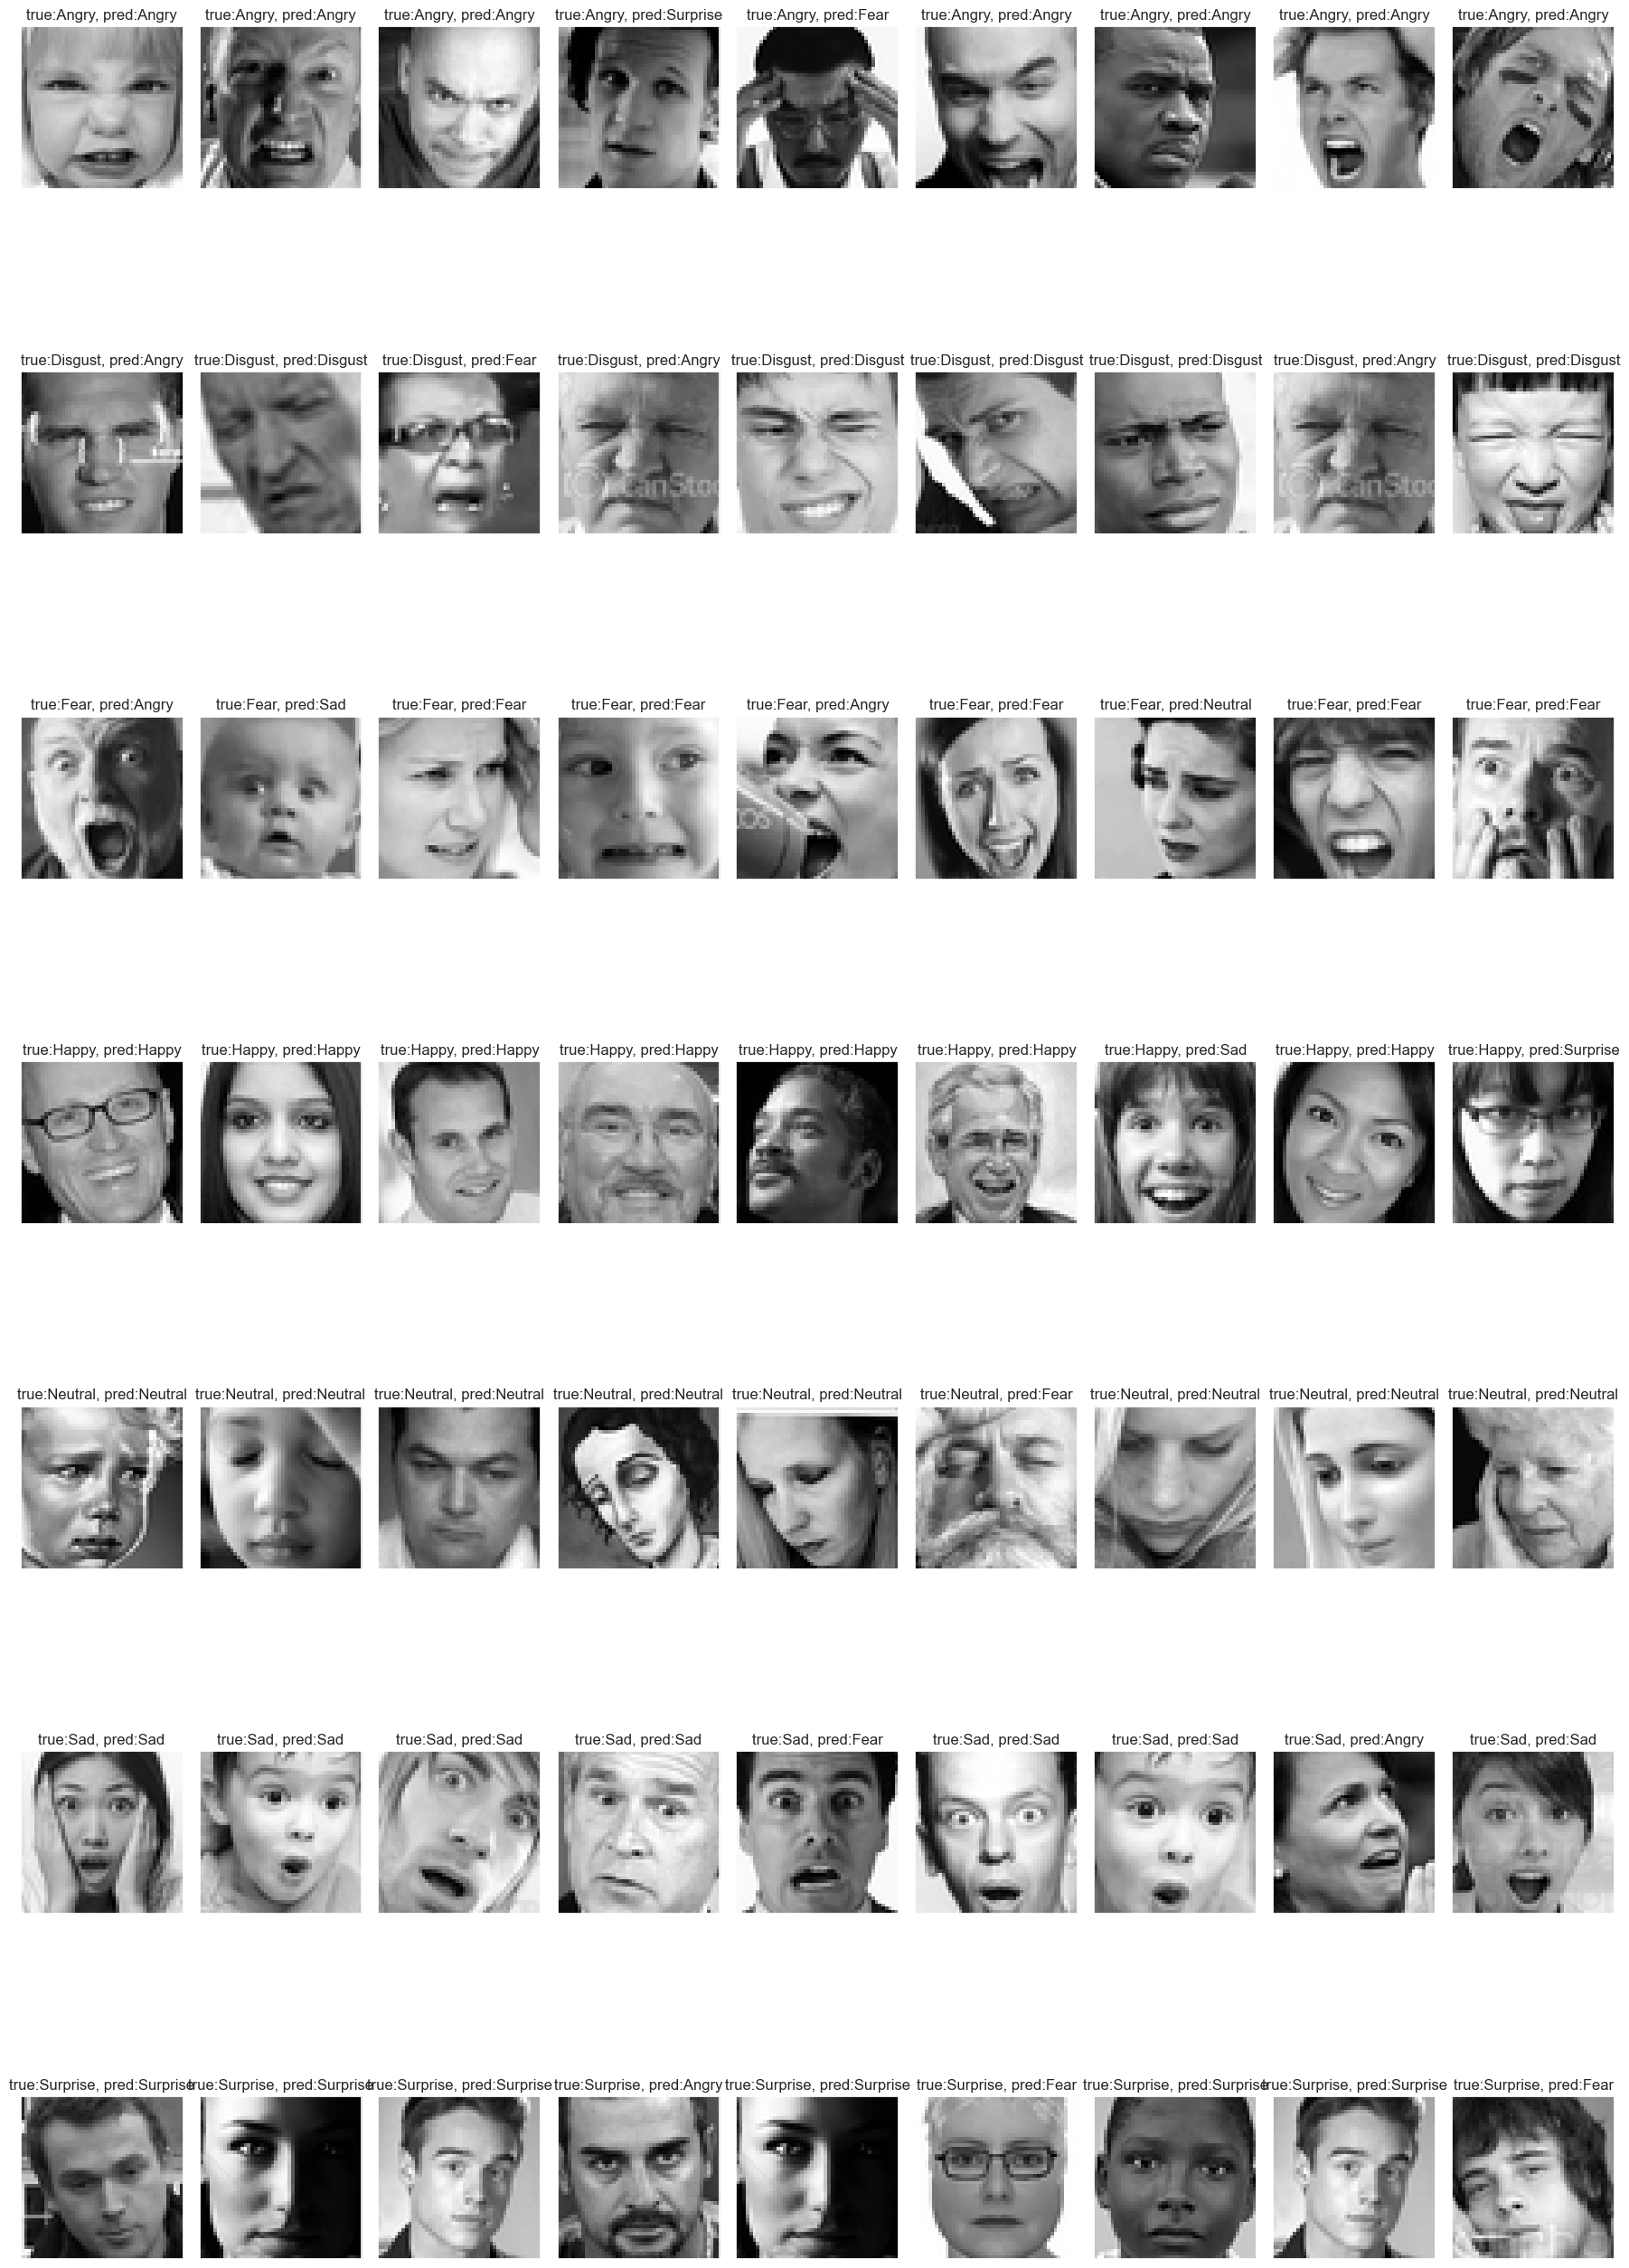

In [55]:
# np.random.seed(2)
# random_sad_imgs = np.random.choice(np.where(y_valid[:, 5]==1)[0], size=9)
# random_neutral_imgs = np.random.choice(np.where(y_valid[:, 4]==1)[0], size=9)

# fig, axes = plt.subplots(2, 9, figsize=(18, 4))

# for i, (sadidx, neuidx) in enumerate(zip(random_sad_imgs, random_neutral_imgs)):
#     # For sad images
#     sample_img_sad = X_valid[sadidx, :, :, 0]
#     axes[0, i].imshow(sample_img_sad, cmap='gray')
#     axes[0, i].set_xticks([])
#     axes[0, i].set_yticks([])
#     pred_sad = np.argmax(model.predict(sample_img_sad.reshape(1, 48, 48, 1)))
#     axes[0, i].set_title(f"true:sad, pred:{mapper[pred_sad]}")

#     # For neutral images
#     sample_img_neutral = X_valid[neuidx, :, :, 0]
#     axes[1, i].imshow(sample_img_neutral, cmap='gray')
#     axes[1, i].set_xticks([])
#     axes[1, i].set_yticks([])
#     pred_neutral = np.argmax(model.predict(sample_img_neutral.reshape(1, 48, 48, 1)))
#     axes[1, i].set_title(f"true:neut, pred:{mapper[pred_neutral]}")

# plt.tight_layout()
# plt.show()

np.random.seed(2)

# Select random images for different emotion classes
random_images = {}
for emotion_idx in range(len(mapper)):
    random_images[emotion_idx] = np.random.choice(np.where(y_valid[:, emotion_idx]==1)[0], size=9)

# Create subplots
fig, axes = plt.subplots(len(mapper), 9, figsize=(18, 4*len(mapper)))

# Loop through each emotion class
for emotion_idx in range(len(mapper)):
    for i, img_idx in enumerate(random_images[emotion_idx]):
        # For the selected emotion class
        sample_img = X_valid[img_idx, :, :, 0]
        axes[emotion_idx, i].imshow(sample_img, cmap='gray')
        axes[emotion_idx, i].set_xticks([])
        axes[emotion_idx, i].set_yticks([])
        pred_label = np.argmax(model.predict(sample_img.reshape(1, 48, 48, 1)))
        axes[emotion_idx, i].set_title(f"true:{mapper[emotion_idx]}, pred:{mapper[pred_label]}")

plt.tight_layout()
plt.show()
